# Prediction of COVID-19 Around the World

| Student | __Angela Amador__ |
| ------ | ----- |
| TMU Student Number | __500259095__ |
| Supervisor | __Tamer Abdou, PhD__  |

I aim to demonstrate how Machine Learning (ML) models are able to predict the spread of COVID-19 around the world.

First, I will explore the dataset to get insights and better understand patterns, detect error and outliers, and find relationships between variables.

Then I will evaluate prediction models and evaluate their fitness.

## Preparation

The dataset is taken from Our World in Data website, officially collected by Our World in Data team: https://covid.ourworldindata.org/data/owid-covid-data.csv.

The dataset, provides COVID-19 information collected by [Our World in Data](https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset) and made available by the Kaggle community https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset/download?datasetVersionNumber=418. This dataset is updated daily.

In [5]:
import datetime
import time
import warnings

# Use jupyter_black to automatically format the code
import black
import jupyter_black
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import multiprocess as mp
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from ydata_profiling import ProfileReport

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="INFO",
    target_version=black.TargetVersion.PY310,
)

# Use pycodestyle to enforce coding standards.
%load_ext pycodestyle_magic
%pycodestyle_on

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"

# Seeding the pseudo random number generator with a specific value
# makes results predictable and reproducible
np.random.seed(873409)

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


## Helper Functions

In [6]:
def df_details(title, dfs):
    """ Generate a markdown table with details of a dataframe """

    output = f"| {'' if title is None else title} |"
    for label, df in dfs.items():
        output += f" {label} |"

    output += "\n| :--- |" + " ---: |" * len(dfs)

    output += "\n| Number of observations |"
    for label, df in dfs.items():
        output += f" {df.shape[0]} |"

    output += "\n| Number of attributes |"
    for label, df in dfs.items():
        output += f" {df.shape[1]} |"

    output += "\n| Size |"
    for label, df in dfs.items():
        output += f" {df.size} |"

    display(Markdown(output))


def describe_nan(df):
    "Produce a summary count of nan counts in dataframe"
    return pd.DataFrame(
        [
            (
                i,
                df[df[i].isna()].shape[0],
                df[df[i].isna()].shape[0] / df.shape[0]
            )
            for i in df.columns
        ],
        columns=["column", "nan_count", "nan_rate"],
    )


def show_items_in_table(label, items_list, n_cols=8):
    """"Shows a list of elements in table format for easier inspection"""
    output = "" + ("" if label is None else label) + "\n"
    output += "|" + " |" * n_cols + "\n"
    output += "|" + " :--- |" * n_cols + "\n"
    row = 0
    while (row * n_cols < len(items_list)):
        output += "|" + \
            "".join([
                f" `{x}` |" for x in items_list[row*n_cols:(row+1)*n_cols]
                ])
        if (row+1)*n_cols > len(items_list):
            output += " |" * (n_cols - (len(items_list) % n_cols))
        output += "\n"
        row += 1
    display(Markdown(output))


def nan_density_plot(_df, plotsize=(16, 8)):
    """ Groups the values in each row of the dataframe by week,
    counts how many there are in each week, and generates a violin
    plot to allow exploring the occurrence of NaNs in the dataframe
    through time    """
    df = _df.copy()
    df.set_index("date", inplace=True)
    df = df.\
        isna().\
        groupby(
            df.index - df.index.weekday * np.timedelta64(1, 'D'),
            sort=False
        ).\
        sum().\
        reset_index()
    tsum = df.loc[:, df.columns != "date"].sum(axis=0)
    column_labels = (f"{i} [{tsum[i]}]" for i in tsum.index)

    # describe_nan(raw_data).sort_values(by="nan_rate", ascending=False).query(
    #     "nan_rate >= 0"
    # )
    # sum(df["continent"])
    # sum(df["people_fully_vaccinated_per_hundred"])

    fontsize = 10
    fig, axes = plt.subplots(figsize=plotsize)
    axes.violinplot(df.loc[:, df.columns != "date"],
                    showextrema=False,
                    vert=True
                    )

    axes.set_title('NaN density over time for the features in the dataset')
    axes.xaxis.grid(True)
    axes.set_xlabel('Dataset Feature')
    axes.set_ylabel('Date')
    # axes.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes.get_yaxis().set_visible(False)
    axes.set_xticks(
        [x + 1 for x in range(len(df.loc[:, df.columns != "date"].columns))],
        labels=column_labels
    )
    plt.xticks(rotation=90)
    # plt.yticks(df.index, rotation=90)

    return plt.show()


def results_to_table(label, data):
    """
    Displays model details from a dictionary in a Markdown table
    """
    output = ""
    cols = {}
    for m, d in data.items():
        cols.update(d)
    cols = list(cols.keys())
    # cols.remove("model")
    output += "| %s | " % label + " | ".join(cols) + " |\n"
    output += "| :--- |" + " :--- |" * len(cols) + "\n"
    for m, d in data.items():
        output += "| %s |" % m
        for c in cols:
            output += " %s |" % d.get(c, "")
        output += "\n"
    display(Markdown(output))

## Load file and explore data

For the purpose of this study I'm analyzing the data with information up to Oct 7th, 2023.

In [7]:
# Load file
raw_data = pd.read_csv("archive.zip", sep=",")

# Set the appropriate data type for the date column.
raw_data['date'] = pd.to_datetime(raw_data['date'])

display(Markdown("> Explore the data as loaded from the source:"))
raw_data.head()

display(Markdown(f"""
> The dataset has a total of **{raw_data["total_cases"].isna().sum()}**
observations with NaN values for the `total_cases` column.<br>As this
will be my predicted feature, NaNs don't add value to the
model so I'll remove them.
"""))
raw_data_before = raw_data
raw_data = raw_data[raw_data["total_cases"].notna()]
df_details("Removing observations with NaN in `total_cases`", {
    "Before": raw_data_before,
    "After": raw_data
    }
)

# Int32 supports NaN values, but as there no longer are NaN values for
# the total_cases feature I can set the data type to int32.
raw_data["total_cases"] = raw_data["total_cases"].astype('int32')

> Explore the data as loaded from the source:

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN



> The dataset has a total of **37895**
observations with NaN values for the `total_cases` column.<br>As this
will be my predicted feature, NaNs don't add value to the
model so I'll remove them.


| Removing observations with NaN in `total_cases` | Before | After |
| :--- | ---: | ---: |
| Number of observations | 346567 | 308672 |
| Number of attributes | 67 | 67 |
| Size | 23219989 | 20681024 |

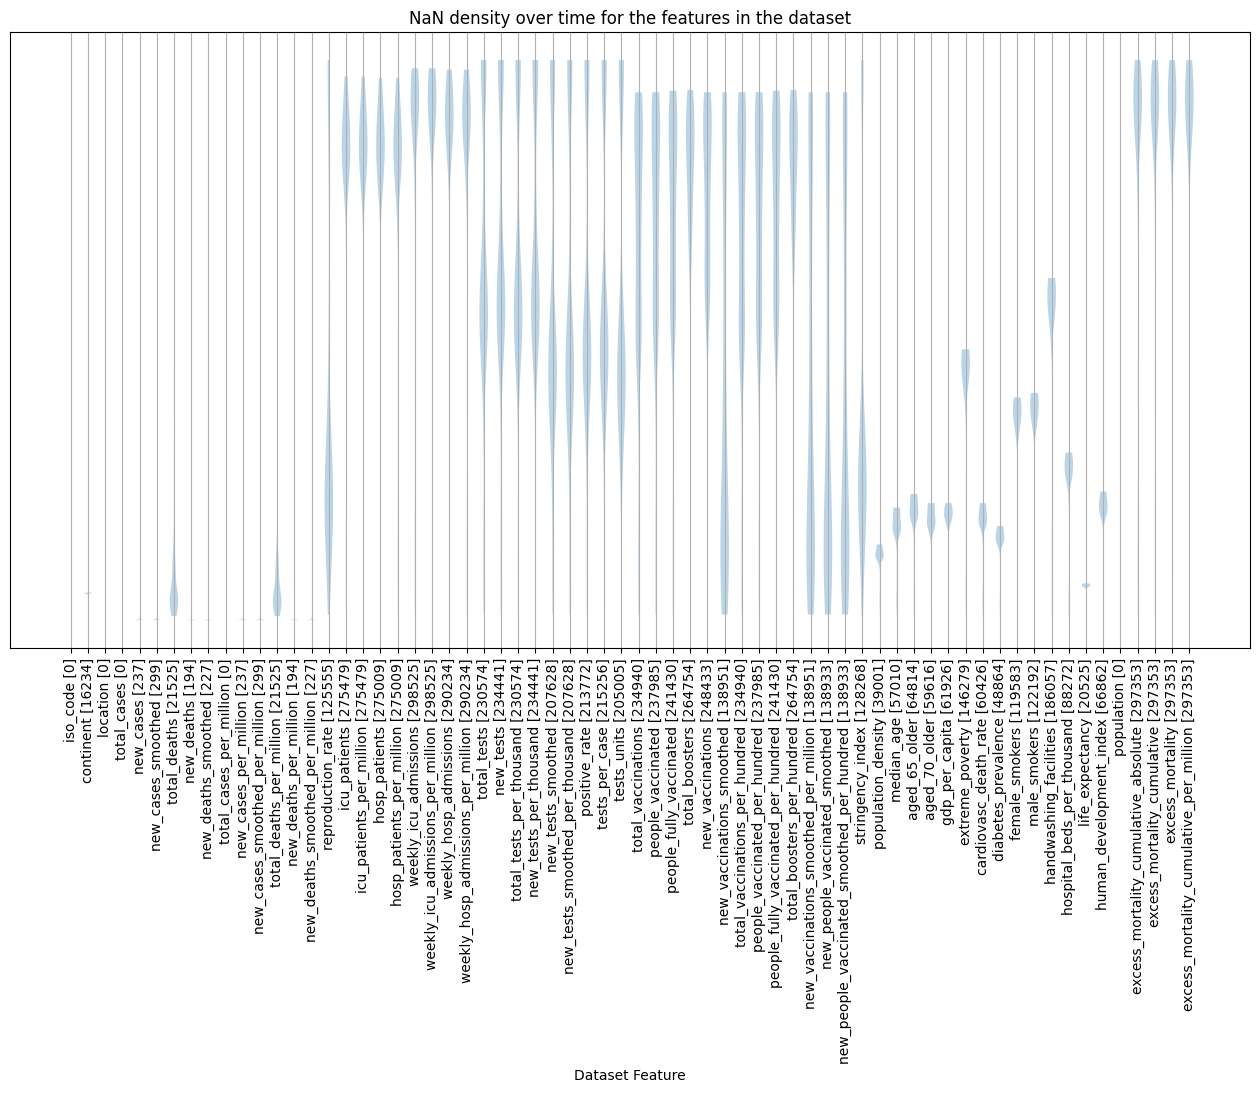

In [8]:
nan_density_plot(raw_data)

Due to the large number of different values for the `iso_code` and `location` features, I need to make a decision of droping information outside Noth America.

Because the original dataset had 346,567 observations and 67 attributes. If I apply One Hot Encoding, the dataset will be left with 552 attributes.

In [9]:
raw_data_before = raw_data

raw_data = raw_data[raw_data["continent"].isin(["North America"])]
# raw_data.drop(raw_data[raw_data.location in [
#     "Canada",
#     "United States",
#     "Mexico"
# ]].index)

df_details("Remove observations from outside North America",
           {
               "Before": raw_data_before,
               "After": raw_data,
            })

| Remove observations from outside North America | Before | After |
| :--- | ---: | ---: |
| Number of observations | 308672 | 53290 |
| Number of attributes | 67 | 67 |
| Size | 20681024 | 3570430 |

In [10]:
# raw_data['continent'].unique()
# t = raw_data.copy()
# t['continent'].value_counts()
# t = t[t['continent']=="North America"]
# t['continent'].unique()

### Check the data type and metadata of the attributes

Look at meta information about data, such as data types and null values.

In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53290 entries, 9681 to 328906
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   iso_code                                    53290 non-null  object        
 1   continent                                   53290 non-null  object        
 2   location                                    53290 non-null  object        
 3   date                                        53290 non-null  datetime64[ns]
 4   total_cases                                 53290 non-null  int32         
 5   new_cases                                   53141 non-null  float64       
 6   new_cases_smoothed                          53136 non-null  float64       
 7   total_deaths                                48572 non-null  float64       
 8   new_deaths                                  53141 non-null  float64       
 9   new_dea

Look at meta information about numeric data, we can also see if there any
extreme values.

In [12]:
raw_data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date,53290,2021-12-23 13:03:00.911991040,2020-01-20 00:00:00,2021-02-02 00:00:00,2021-12-24 00:00:00,2022-11-14 00:00:00,2023-10-04 00:00:00,NaN
total_cases,53290.0,1678566.797598,1.0,2185.5,12197.0,134934.5,103436829.0,10672526.58947
new_cases,53141.0,2342.683898,0.0,0.0,0.0,55.0,1265520.0,22936.6498
new_cases_smoothed,53136.0,2342.900734,0.0,0.143,8.0,115.0,809735.286,21041.999241
total_deaths,48572.0,28414.192477,1.0,30.0,188.0,3124.0,1127152.0,137765.033903
...,...,...,...,...,...,...,...,...
population,53290.0,15075157.235767,4413.0,56494.0,191173.0,5180836.0,338289856.0,56079213.794365
excess_mortality_cumulative_absolute,1613.0,140745.483747,-13646.999,162.2,3318.4998,47146.03,1276845.0,306575.429912
excess_mortality_cumulative,1613.0,10.91907,-27.35,3.37,9.67,15.42,57.14,12.279025
excess_mortality,1613.0,13.83938,-95.92,-1.32,7.58,19.4,343.02,30.020187


### Remove data pre-dating COVID vaccine availability

Multiple vaccines became available on the second semester of 2020. By December most countries had access to approved vaccines.

As vaccinations changed the behaviour of the pandemic I will remove data before Jan 1st, 2021 and consider only data collected after vaccines became available.

In [13]:
raw_data_before = raw_data
raw_data = raw_data.\
    drop(raw_data[raw_data["date"] < pd.Timestamp(2021, 1, 1)].index)

df_details("Remove observations before vaccines were available on Jan 2021)",
           {
               "Before": raw_data_before,
               "After": raw_data,
            })

| Remove observations before vaccines were available on Jan 2021) | Before | After |
| :--- | ---: | ---: |
| Number of observations | 53290 | 41287 |
| Number of attributes | 67 | 67 |
| Size | 3570430 | 2766229 |

### One Hot Encoding in Machine Learning

Machine Learning models do not work with categorical data and to fit this data into the machine learning model it needs to be converted into numerical data. One technique is to use One Hot Encoding technique. One hot encoding is a technique that we use to represent categorical variables as numerical values in a machine learning model.

We have four catgorical variables in the dataset: `iso_code`, `continent`, `location` and `tests_units`.

In [14]:
print("Describe categorical variables")

print("\niso_code:")
raw_data['iso_code'].describe(include='all')

print("\ncontinent:")
raw_data['continent'].describe(include='all')

print("\nlocation:")
raw_data['location'].describe(include='all')

print("\ntests_units:")
raw_data['tests_units'].describe(include='all')

Describe categorical variables

iso_code:


count     41287
unique       41
top         AIA
freq       1007
Name: iso_code, dtype: object


continent:


count             41287
unique                1
top       North America
freq              41287
Name: continent, dtype: object


location:


count        41287
unique          41
top       Anguilla
freq          1007
Name: location, dtype: object


tests_units:


count                9029
unique                  3
top       tests performed
freq                 5551
Name: tests_units, dtype: object

#### Create a Categorical DataFrame

The `categorical_df` dataframe will contain only the selected categorical columns.

In [15]:
categorical_cols = ['iso_code', 'continent', 'location', 'tests_units']
categorical_df = raw_data[categorical_cols]
categorical_df.head()
categorical_df['continent'].unique()

,iso_code,continent,location,tests_units
9961,AIA,North America,Anguilla,NaN
9962,AIA,North America,Anguilla,NaN
9963,AIA,North America,Anguilla,NaN
9964,AIA,North America,Anguilla,NaN
9965,AIA,North America,Anguilla,NaN


array(['North America'], dtype=object)

#### Finding Unique Values

Number of unique values for the categorical features:

In [16]:
output = f"""| Feature | Number of unique values |\n| :--- | ---: |\n"""
for x in categorical_df.columns:
    output += f"| {x} | {len(categorical_df[x].unique())} |\n"
display(Markdown(output))

| Feature | Number of unique values |
| :--- | ---: |
| iso_code | 41 |
| continent | 1 |
| location | 41 |
| tests_units | 4 |


Examine how many columns we'll obtain after One Hot Encoding these variables.

In [17]:
pd.get_dummies(categorical_df, drop_first=False).shape

(41287, 86)

#### Run One Hot Encoding
Apply One Hot Encoding to all 4 categorical variables: `iso_code`, `continent`, `location` and `tests_units`.

In [18]:
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)

# One-hot encoding 'iso_code' column
origin_encoded = encoder.fit_transform(raw_data[['iso_code']])
df_encoded1 = pd.concat([
    raw_data,
    pd.DataFrame(
        origin_encoded,
        raw_data.index,
        columns=encoder.categories_[0]
    )],
    axis=1)

# If encoding iso_code created a column NaN at the end, eliminate this column
if pd.isna(df_encoded1.columns[-1]):
    display(Markdown(
        "> NaN column is being removed after encoding iso_code"))
    df_encoded1 = df_encoded1.iloc[:, :-1]

if df_encoded1.columns.is_unique is False:
    # print('\nDuplicate columns after iso_code encoding\n')
    duplicate_cols = df_encoded1.columns[df_encoded1.columns.duplicated()]
    display(Markdown("> Duplicate columns %s are being removed." %
                     duplicate_cols))
    df_encoded1.drop(columns=duplicate_cols, inplace=True)

# One-hot encoding 'continent' column
origin_encoded = encoder.fit_transform(df_encoded1[['continent']])
df_encoded2 = pd.concat([
    df_encoded1,
    pd.DataFrame(
        origin_encoded,
        df_encoded1.index,
        columns=encoder.categories_[0]
    )], axis=1)

# If encoding continent created a column NaN at the end, eliminate this column
if pd.isna(df_encoded2.columns[-1]):
    display(Markdown(
        "> NaN column is being removed after encoding continent"))
    df_encoded2 = df_encoded2.iloc[:, :-1]

if df_encoded2.columns.is_unique is False:
    # print('\nDuplicate columns after continent encoding\n')
    duplicate_cols = df_encoded2.columns[df_encoded2.columns.duplicated()]
    display(Markdown("> Duplicate columns %s are being removed." %
                     duplicate_cols))
    df_encoded2.drop(columns=duplicate_cols, inplace=True)

# One-hot encoding 'location' column
origin_encoded = encoder.fit_transform(df_encoded2[['location']])
df_encoded3 = pd.concat([
    df_encoded2,
    pd.DataFrame(
        origin_encoded,
        df_encoded2.index,
        columns=encoder.categories_[0]
    )], axis=1)

# If encoding location created a column NaN at the end, eliminate this column
if pd.isna(df_encoded3.columns[-1]):
    display(Markdown(
        "> NaN column is being removed after encoding location"))
    df_encoded3 = df_encoded3.iloc[:, :-1]

if df_encoded3.columns.is_unique is False:
    # print('\nDuplicate columns after location encoding\n')
    duplicate_cols = df_encoded3.columns[df_encoded3.columns.duplicated()]
    display(Markdown("> Duplicate columns %s are being removed." %
                     duplicate_cols))
    df_encoded3.drop(columns=duplicate_cols, inplace=True)

# One-hot encoding 'tests_units' column
origin_encoded = encoder.fit_transform(df_encoded3[['tests_units']])
df_encoded4 = pd.concat([
    df_encoded3,
    pd.DataFrame(
        origin_encoded,
        df_encoded3.index,
        columns=encoder.categories_[0]
    )], axis=1)

# set the max columns to none
# pd.set_option('display.max_columns', None)

# If encoding tests_units created a column NaN at the end, eliminate
# this column
if pd.isna(df_encoded4.columns[-1]):
    display(Markdown(
        "> NaN column is being removed after encoding tests_units"))
    df_encoded4 = df_encoded4.iloc[:, :-1]

if df_encoded4.columns.is_unique is False:
    duplicate_cols = df_encoded4.columns[df_encoded4.columns.duplicated()]
    display(Markdown("> Duplicate columns %s are being removed." %
                     duplicate_cols))
    df_encoded4.drop(columns=duplicate_cols, inplace=True)

df_details("One hot encoding categorical variables:", {
    "Initially": raw_data,
    "isocode": df_encoded1,
    "continent": df_encoded2,
    "location": df_encoded3,
    "test_units": df_encoded4,
    })

display(Markdown(f"""
We have a total of {raw_data.shape[1]} columns from the original dataset
- After adding {df_encoded1.shape[1]-raw_data.shape[1]} unique
  values from iso_code, we get a total of {df_encoded1.shape[1]} columns
- After adding {df_encoded2.shape[1]-df_encoded1.shape[1]} unique
  values from continent, we get a total of {df_encoded2.shape[1]} columns
- After adding {df_encoded3.shape[1]-df_encoded2.shape[1]} unique
  values from location, we get a total of {df_encoded3.shape[1]} columns
- After adding {df_encoded4.shape[1]-df_encoded3.shape[1]} unique
  values from tests_units, we get a total of {df_encoded4.shape[1]} columns
"""))

# df_encoded4.columns
# df_encoded4.columns[-10:]
# df_encoded4.info()
# list(df_encoded4.columns)
# list(pd.get_dummies(categorical_df, drop_first=True).columns)
df_encoded = df_encoded4
df_encoded4.head()

> NaN column is being removed after encoding tests_units

| One hot encoding categorical variables: | Initially | isocode | continent | location | test_units |
| :--- | ---: | ---: | ---: | ---: | ---: |
| Number of observations | 41287 | 41287 | 41287 | 41287 | 41287 |
| Number of attributes | 67 | 108 | 109 | 150 | 153 |
| Size | 2766229 | 4458996 | 4500283 | 6193050 | 6316911 |


We have a total of 67 columns from the original dataset
- After adding 41 unique
  values from iso_code, we get a total of 108 columns
- After adding 1 unique
  values from continent, we get a total of 109 columns
- After adding 41 unique
  values from location, we get a total of 150 columns
- After adding 3 unique
  values from tests_units, we get a total of 153 columns


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Sint Maarten (Dutch part),Trinidad and Tobago,Turks and Caicos Islands,United States,United States Virgin Islands,people tested,samples tested,tests performed
9961,AIA,North America,Anguilla,2021-01-01,13,0.0,0.286,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9962,AIA,North America,Anguilla,2021-01-02,14,1.0,0.429,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9963,AIA,North America,Anguilla,2021-01-03,15,1.0,0.429,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9964,AIA,North America,Anguilla,2021-01-04,15,0.0,0.429,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9965,AIA,North America,Anguilla,2021-01-05,15,0.0,0.286,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
show_items_in_table(None, df_encoded4.columns, 5)


| | | | | |
| :--- | :--- | :--- | :--- | :--- |
| `iso_code` | `continent` | `location` | `date` | `total_cases` |
| `new_cases` | `new_cases_smoothed` | `total_deaths` | `new_deaths` | `new_deaths_smoothed` |
| `total_cases_per_million` | `new_cases_per_million` | `new_cases_smoothed_per_million` | `total_deaths_per_million` | `new_deaths_per_million` |
| `new_deaths_smoothed_per_million` | `reproduction_rate` | `icu_patients` | `icu_patients_per_million` | `hosp_patients` |
| `hosp_patients_per_million` | `weekly_icu_admissions` | `weekly_icu_admissions_per_million` | `weekly_hosp_admissions` | `weekly_hosp_admissions_per_million` |
| `total_tests` | `new_tests` | `total_tests_per_thousand` | `new_tests_per_thousand` | `new_tests_smoothed` |
| `new_tests_smoothed_per_thousand` | `positive_rate` | `tests_per_case` | `tests_units` | `total_vaccinations` |
| `people_vaccinated` | `people_fully_vaccinated` | `total_boosters` | `new_vaccinations` | `new_vaccinations_smoothed` |
| `total_vaccinations_per_hundred` | `people_vaccinated_per_hundred` | `people_fully_vaccinated_per_hundred` | `total_boosters_per_hundred` | `new_vaccinations_smoothed_per_million` |
| `new_people_vaccinated_smoothed` | `new_people_vaccinated_smoothed_per_hundred` | `stringency_index` | `population_density` | `median_age` |
| `aged_65_older` | `aged_70_older` | `gdp_per_capita` | `extreme_poverty` | `cardiovasc_death_rate` |
| `diabetes_prevalence` | `female_smokers` | `male_smokers` | `handwashing_facilities` | `hospital_beds_per_thousand` |
| `life_expectancy` | `human_development_index` | `population` | `excess_mortality_cumulative_absolute` | `excess_mortality_cumulative` |
| `excess_mortality` | `excess_mortality_cumulative_per_million` | `ABW` | `AIA` | `ATG` |
| `BES` | `BHS` | `BLM` | `BLZ` | `BMU` |
| `BRB` | `CAN` | `CRI` | `CUB` | `CUW` |
| `CYM` | `DMA` | `DOM` | `GLP` | `GRD` |
| `GRL` | `GTM` | `HND` | `HTI` | `JAM` |
| `KNA` | `LCA` | `MAF` | `MEX` | `MSR` |
| `MTQ` | `NIC` | `PAN` | `PRI` | `SLV` |
| `SPM` | `SXM` | `TCA` | `TTO` | `USA` |
| `VCT` | `VGB` | `VIR` | `North America` | `Anguilla` |
| `Antigua and Barbuda` | `Aruba` | `Bahamas` | `Barbados` | `Belize` |
| `Bermuda` | `Bonaire Sint Eustatius and Saba` | `British Virgin Islands` | `Canada` | `Cayman Islands` |
| `Costa Rica` | `Cuba` | `Curacao` | `Dominica` | `Dominican Republic` |
| `El Salvador` | `Greenland` | `Grenada` | `Guadeloupe` | `Guatemala` |
| `Haiti` | `Honduras` | `Jamaica` | `Martinique` | `Mexico` |
| `Montserrat` | `Nicaragua` | `Panama` | `Puerto Rico` | `Saint Barthelemy` |
| `Saint Kitts and Nevis` | `Saint Lucia` | `Saint Martin (French part)` | `Saint Pierre and Miquelon` | `Saint Vincent and the Grenadines` |
| `Sint Maarten (Dutch part)` | `Trinidad and Tobago` | `Turks and Caicos Islands` | `United States` | `United States Virgin Islands` |
| `people tested` | `samples tested` | `tests performed` | | |


In [20]:
# Drop the categorical variables and leave the encoded columns
display(Markdown("> Columns to drop: %s" % categorical_cols))
df_encoded_before = df_encoded
df_encoded = df_encoded.drop(columns=categorical_cols)

df_details("Eliminating original columns for categorial attributes and " +
           "leaving encoded columns from One Hot Encoding", {
               "Before": df_encoded_before,
               "After": df_encoded
           })

# df_encoded.head()

> Columns to drop: ['iso_code', 'continent', 'location', 'tests_units']

| Eliminating original columns for categorial attributes and leaving encoded columns from One Hot Encoding | Before | After |
| :--- | ---: | ---: |
| Number of observations | 41287 | 41287 |
| Number of attributes | 153 | 149 |
| Size | 6316911 | 6151763 |

### Convert attribute `date` to epoch

In [21]:
# df_encoded.head()
df_encoded["date"] = df_encoded["date"].astype("int64")/10**9
# df_encoded.head()

## Data Splitting

One of the first decisions to make is how to utilize the existing data. One common technique is to split the data into two groups typically referred to as the Training and Testing sets. The Training set is used to develop
models and feature sets; it is the substrate for estimating parameters, comparing models, and all of the other activities required to reach a final model. The Testing set is used only at the conclusion of these activities for estimating a final, unbiased assessment of the model’s performance. It is critical that the Testing set is not used prior to this point. Looking at the Testing set results would bias the outcomes since the Testing data will have become part of the model development process. Reference: [Feature Engineering and Selection A Practical Approach for Predictive Models](http://www.feat.engineering/).

In [22]:
# Labels are the values we want to predict
labels = df_encoded['total_cases']
# Saving label name
labels_list = ['total_cases']
# Convert to numpy array
labels = np.array(labels)

# Remove the labels from the features
# axis 1 refers to the columns
features = df_encoded.drop('total_cases', axis=1)
# Saving feature names
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

new_cols = feature_list + labels_list
new_df_encoded = df_encoded[new_cols]
# new_df_encoded.head(10)
# new_df_encoded.tail(10)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=.3,
    random_state=1121218
)

df_training_X = pd.DataFrame(
        X_train,
        columns=feature_list
    )

df_training_y = pd.DataFrame(
        y_train,
        columns=labels_list
    )

df_training = df_training_X.copy()
df_training['total_cases'] = y_train

df_test_X = pd.DataFrame(
        X_test,
        columns=feature_list
    )

df_test = df_test_X.copy()
df_test['total_cases'] = y_test

df_validation = pd.concat([df_training, df_test])
# df_validation.head(10)
# df_validation.tail(10)

df_details(None, {
    "Source data set": df_encoded,
    "Training data (sub)set": df_training,
    "Testing data (sub)set": df_test
    })

# display(Markdown(
#     "> Date range for the training data set: **%s** to **%s**" %
#     (min(df_training["date"]), max(df_training["date"]))))
# display(Markdown(
#     "> Date range for the test data set: **%s** to **%s**" %
#     (min(df_test["date"]), max(df_test["date"]))))

|  | Source data set | Training data (sub)set | Testing data (sub)set |
| :--- | ---: | ---: | ---: |
| Number of observations | 41287 | 28900 | 12387 |
| Number of attributes | 149 | 149 | 149 |
| Size | 6151763 | 4306100 | 1845663 |

## Data Cleaning

Data cleaning will take place only on the training dataset excluding predictive attribute `total_cases`.

### Identify Columns That Contain a Single Value

In [23]:
df_training_before = df_training_X.copy()
df_training = df_training_X.copy()

# get number of unique values for each column
counts = df_training.nunique()

# record columns to delete
to_del = [i for i, v in enumerate(counts) if v == 1]
cols_to_del = df_training.columns[to_del]
display(Markdown(
    f"> Columns to remove with one unique value: {cols_to_del}"
))

# drop useless columns
df_training.drop(cols_to_del, axis=1, inplace=True)
df_details(
    "Training data set after removing columns with a single value",
    {
        "Before": df_training_before,
        "After": df_training
    })

> Columns to remove with one unique value: Index(['North America'], dtype='object')

| Training data set after removing columns with a single value | Before | After |
| :--- | ---: | ---: |
| Number of observations | 28900 | 28900 |
| Number of attributes | 148 | 147 |
| Size | 4277200 | 4248300 |

### Remove data columns with too many NaN values

We can calculate the ratio of missing values using a simple formula. The formula is the number of missing values in each column divided by the total number of observations. Generally, we can drop variables having a missing-value ratio of more than 60% or 70%. For my purpose I am going to use a threashold of 60% missing values and remove those attributes.

In [24]:
# Defining threashold of 60% missing values
threashold_NaN = 0.60

pd.options.display.max_rows = None

display(Markdown(
    f"Attributes with more than {threashold_NaN*100}% of missing values:"
    ))

describe_nan(df_training).sort_values(by="nan_rate", ascending=False).query(
    "nan_rate >= %s" % threashold_NaN
)

# ((raw_data.isnull() | raw_data.isna()).sum() * 100 / raw_data.index.size).\
# round(2)

Attributes with more than 60.0% of missing values:

,column,nan_count,nan_rate
18,weekly_icu_admissions_per_million,28900,1.000000
17,weekly_icu_admissions,28900,1.000000
19,weekly_hosp_admissions,28200,0.975779
20,weekly_hosp_admissions_per_million,28200,0.975779
61,excess_mortality_cumulative_per_million,28095,0.972145
60,excess_mortality,28095,0.972145
59,excess_mortality_cumulative,28095,0.972145
58,excess_mortality_cumulative_absolute,28095,0.972145
13,icu_patients,27515,0.952076
16,hosp_patients_per_million,27515,0.952076


In [25]:
drop_columns_NaN = (
    describe_nan(df_training)
    .sort_values(by="nan_rate", ascending=False)
    .query("nan_rate >= %s" % threashold_NaN)[["column"]]
)
drop_columns_NaN = drop_columns_NaN["column"].to_list()

# Removing data columns with too many missing values
# drop_columns_NaN
df_training_NaN = df_training.drop(drop_columns_NaN, axis=1, inplace=False)

df_details(f"Removing columns with more than {threashold_NaN*100}% " +
           "of missing values",
           {
               "Before": df_training,
               "After": df_training_NaN
            })
# df_training_NaN.info()

| Removing columns with more than 60.0% of missing values | Before | After |
| :--- | ---: | ---: |
| Number of observations | 28900 | 28900 |
| Number of attributes | 147 | 113 |
| Size | 4248300 | 3265700 |

### Feature Selection - Correlation and P-value
From https://www.kaggle.com/code/bbloggsbott/feature-selection-correlation-and-p-value:
 
> #### How does correlation help in feature selection?
> Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.
> 
> #### What is p-value?
> P-value or probability value or asymptotic significance is a probability value for a given statistical model that, if the null hyothesis is true, a set of statistical observations more commonly known as the statistical summary is greater than or equal in magnitude to the observed results.
> 
> #### How does p-value help in feature selection?
> Removal of different features from the dataset will have different effects on the p-value for the dataset. We can remove different features and measure the p-value in each case. These measured p-values can be used to decide whether to keep a feature or not.
> 
Generate the correlation matrix:

In [26]:
df_training_corr = df_training_NaN

# df_training_NaN.dtypes

# # encode the Categorical Variable Date
# label_encoder = LabelEncoder()
# df_training_corr.iloc[:, 0] = label_encoder.fit_transform(
#     df_training_corr.iloc[:, 0]).astype('int32')

# df_training_corr.head()

corr = df_training_corr.corr()
corr.head(15)

,date,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Sint Maarten (Dutch part),Trinidad and Tobago,Turks and Caicos Islands,United States,United States Virgin Islands,people tested,samples tested,tests performed
date,1.000000,-0.049692,-0.052180,0.034232,-0.098585,-0.108458,0.554583,-0.054475,-0.124241,0.463632,...,-0.006491,0.004957,0.000868,0.001459,-0.005034,-0.004137,-0.000721,-0.195999,-0.131652,-0.272381
new_cases,-0.049692,1.000000,0.910469,0.501542,0.727676,0.648764,0.009653,0.039232,0.063080,0.139649,...,-0.016337,-0.016205,-0.016486,-0.015042,-0.016500,0.572962,-0.016329,0.002340,-0.013838,0.171946
new_cases_smoothed,-0.052180,0.910469,1.000000,0.562441,0.669171,0.726357,0.013558,0.029098,0.069272,0.158092,...,-0.018084,-0.017930,-0.018244,-0.016625,-0.018262,0.636039,-0.018075,0.002920,-0.015399,0.185231
total_deaths,0.034232,0.501542,0.562441,1.000000,0.526846,0.598874,0.043915,-0.005877,-0.011273,0.380353,...,-0.026343,-0.033927,-0.034784,-0.031138,-0.034804,0.918408,-0.034634,0.053476,-0.033744,0.115666
new_deaths,-0.098585,0.727676,0.669171,0.526846,1.000000,0.901898,-0.018962,0.017929,0.027810,0.139104,...,-0.020094,-0.019884,-0.020286,-0.016813,-0.020295,0.630109,-0.020178,0.072659,-0.017851,0.199401
new_deaths_smoothed,-0.108458,0.648764,0.726357,0.598874,0.901898,1.000000,-0.019370,0.011022,0.028453,0.159847,...,-0.022617,-0.022393,-0.022824,-0.018866,-0.022839,0.709137,-0.022712,0.082864,-0.020080,0.219625
total_cases_per_million,0.554583,0.009653,0.013558,0.043915,-0.018962,-0.019370,1.000000,0.043370,0.107851,0.471001,...,0.172441,-0.085286,0.033932,-0.070690,-0.043517,0.071969,0.011873,-0.158632,-0.125047,-0.172719
new_cases_per_million,-0.054475,0.039232,0.029098,-0.005877,0.017929,0.011022,0.043370,1.000000,0.483220,-0.006967,...,0.042678,-0.014691,0.000466,-0.011168,-0.009206,0.004078,0.001712,-0.006662,-0.014201,0.012916
new_cases_smoothed_per_million,-0.124241,0.063080,0.069272,-0.011273,0.027810,0.028453,0.107851,0.483220,1.000000,-0.001469,...,0.080804,-0.032081,0.002366,-0.024364,-0.021556,0.011265,0.004107,-0.014311,-0.031835,0.032977
total_deaths_per_million,0.463632,0.139649,0.158092,0.380353,0.139104,0.159847,0.471001,-0.006967,-0.001469,1.000000,...,-0.133840,-0.064684,0.095763,0.157388,-0.099058,0.293254,-0.039641,0.010487,-0.127580,-0.051258


Generate the correlation heatmap:

<Axes: >

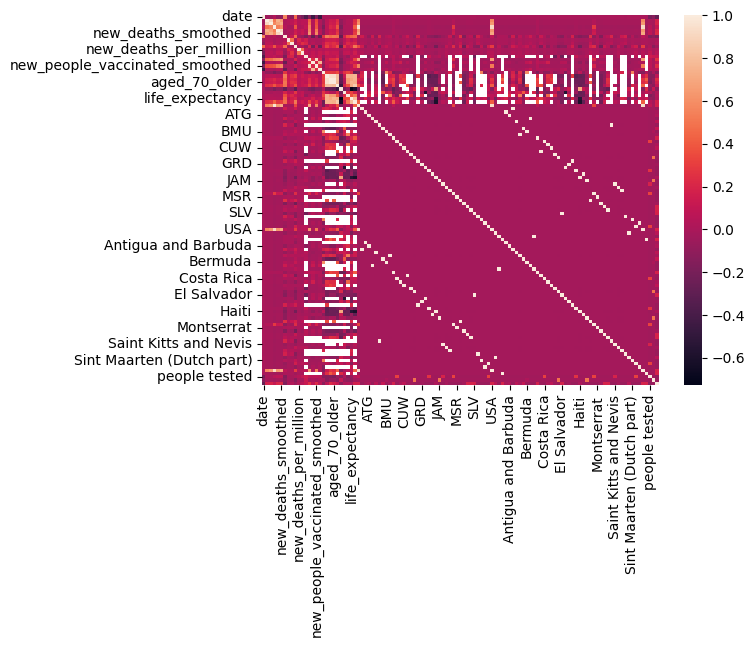

In [27]:
sns.heatmap(corr)

Compare the correlation between features and remove one of two features that have a correlation higher than 0.9:

In [28]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = df_training_corr.columns[columns]
selected_columns.shape

(65,)

In [29]:
show_items_in_table(
    f"A total of {selected_columns.shape[0]} " +
    "columns were selected:",
    selected_columns, 5)

A total of 65 columns were selected:
| | | | | |
| :--- | :--- | :--- | :--- | :--- |
| `date` | `new_cases` | `total_deaths` | `new_deaths` | `total_cases_per_million` |
| `new_cases_per_million` | `new_cases_smoothed_per_million` | `total_deaths_per_million` | `new_deaths_per_million` | `new_deaths_smoothed_per_million` |
| `reproduction_rate` | `new_vaccinations_smoothed` | `new_vaccinations_smoothed_per_million` | `new_people_vaccinated_smoothed_per_hundred` | `population_density` |
| `median_age` | `gdp_per_capita` | `cardiovasc_death_rate` | `diabetes_prevalence` | `hospital_beds_per_thousand` |
| `life_expectancy` | `human_development_index` | `ABW` | `AIA` | `ATG` |
| `BES` | `BHS` | `BLM` | `BLZ` | `BMU` |
| `BRB` | `CAN` | `CRI` | `CUB` | `CUW` |
| `CYM` | `DMA` | `DOM` | `GLP` | `GRD` |
| `GRL` | `GTM` | `HND` | `HTI` | `JAM` |
| `KNA` | `LCA` | `MAF` | `MEX` | `MSR` |
| `MTQ` | `NIC` | `PAN` | `PRI` | `SLV` |
| `SPM` | `SXM` | `TCA` | `TTO` | `VCT` |
| `VGB` | `VIR` | `people tested` | `samples tested` | `tests performed` |


In [30]:
df_training_corr_before = df_training_corr

# The dataset has those columns with correlation less than 0.9
df_training_corr = df_training_corr[selected_columns]

df_details(
    "Removing columns with correlation > 0.9",
    {
        "Before": df_training_corr_before,
        "After": df_training_corr
    })

| Removing columns with correlation > 0.9 | Before | After |
| :--- | ---: | ---: |
| Number of observations | 28900 | 28900 |
| Number of attributes | 113 | 65 |
| Size | 3265700 | 1878500 |

In [31]:
df_training_corr.head()

,date,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,SPM,SXM,TCA,TTO,VCT,VGB,VIR,people tested,samples tested,tests performed
0,1.682208e+09,0.0,41.0,0.0,439339.051,0.000,0.000,1515.600,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.677542e+09,0.0,282.0,0.0,413717.957,0.000,24.154,2648.907,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.677974e+09,0.0,37.0,0.0,457961.061,0.000,0.000,538.401,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.680912e+09,0.0,12.0,0.0,245890.282,0.000,0.000,755.810,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.610237e+09,8766.0,16590.0,127.0,16756.215,227.959,205.847,431.421,3.303,3.559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Selecting columns based on p-value

Next select the columns based on how they affect the p-value.

##### Backward Elimination

Take care of missing values encoded as NaN natively by replacing with the mean:

In [32]:
for c in df_training_corr.columns:
    df_training_corr[c] = df_training_corr[c].\
        fillna(df_training_corr[c].mean())

In [33]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    # x=np.array(x, dtype=float)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
    return x, columns, regressor_OLS.summary()

In [34]:
SL = 0.05
# len(selected_columns)
predictor_column = 'total_cases'
data_modeled, selected_columns, summary = backwardElimination(
    df_training_corr.values,
    df_training_y.values,
    SL,
    selected_columns)

# len(selected_columns)
# data_modeled.shape
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 9.006e+04
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:15:30   Log-Likelihood:            -4.3784e+05
No. Observations:               28900   AIC:                         8.758e+05
Df Residuals:                   28845   BIC:                         8.762e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0077      0.000     19.152      0.000       0.007       0.008
x2           -12.7973      0.371    -34.466      0.000     -13.525     -12.070
x3           120.8144      0.249    484.285      0.000     120.325     121.303
x4          1841.6482     49.464     37.232      0.000    1744.697    1938.599
x5             4.2334      0.079     53.689      0.000       4.079       4.388
x6            90.3033      9.248      9.765      0.000      72.177     108.429
x7          -992.9725     14.828    -66.967      0.000   -1022.036    -963.909
x8          1.165e+04   1490.012      7.817      0.000    8727.584    1.46e+04
x9            -2.0629      0.061    -33.798      0.000      -2.183      -1.943
x10          -13.8536      3.756     -3.688      0.000     -21.215      -6.492
x11         1.417e+05   6.53e+04      2.170      0.030    1.37e+04     2.7e+05
x12         2.231e+04    170.495    130.876      0.000     2.2e+04    2.26e+04
x13         4.096e+05   4001.046    102.363      0.000    4.02e+05    4.17e+05
x14         -818.9714      6.715   -121.962      0.000    -832.133    -805.810
x15        -3.427e+04    470.872    -72.783      0.000   -3.52e+04   -3.33e+04
x16        -4.381e+05   3352.473   -130.665      0.000   -4.45e+05   -4.31e+05
x17         4.444e+05   6983.919     63.629      0.000    4.31e+05    4.58e+05
x18        -3.013e+04   8652.082     -3.482      0.000   -4.71e+04   -1.32e+04
x19        -6.857e+06   5.47e+04   -125.411      0.000   -6.96e+06   -6.75e+06
x20         5.817e+06   6.83e+04     85.179      0.000    5.68e+06    5.95e+06
x21          2.09e+06   5.49e+04     38.112      0.000    1.98e+06     2.2e+06
x22         5.866e+06   5.02e+04    116.761      0.000    5.77e+06    5.96e+06
x23         2.802e+06    4.3e+04     65.107      0.000    2.72e+06    2.89e+06
x24         1.678e+07    1.3e+05    129.445      0.000    1.65e+07     1.7e+07
x25         1.636e+06   4.38e+04     37.347      0.000    1.55e+06    1.72e+06
x26         4.244e+06   3.09e+04    137.178      0.000    4.18e+06     4.3e+06
x27          3.78e+06   4.08e+04     92.638      0.000     3.7e+06    3.86e+06
x28        -1.238e+07   9.65e+04   -128.313      0.000   -1.26e+07   -1.22e+07
x29         2.042e+07    1.6e+05    127.489      0.000    2.01e+07    2.07e+07
x30         4.902e+05   3.66e+04     13.385      0.000    4.18e+05    5.62e+05
x31          9.69e+05   3.28e+04     29.509      0.000    9.05e+05    1.03e+06
x32        -1.278e+06   3.56e+04    -35.860      0.000   -1.35e+06   -1.21e+06
x33           2.7e+07   2.23e+05    121.206      0.000    2.66e+07    2.74e+07
x34        -2.828e+06   3.78e+04    -74.740      0.000    -2.9e+06   -2.75e+06
x35         2.626e+06   4.22e+04     62.167      0.000    2.54e+06    2.71e+06
x36        -2.184e+05   4.58e+04     -4.769      0.000   -3.08e+05   -1.29e+05
x3

Move the results to a new dataframe using the columns selected using the p-value and correlation.

In [35]:
df_training_corr_p_value = pd.DataFrame(
    data=data_modeled,
    columns=selected_columns,
    index=df_training_corr.index
    )

# df_training_corr.head()
# df_training_corr.tail()
# df_training_corr_p_value.head()
# df_training_corr_p_value.tail()

# Also need a dataset that combine both predictive column
# 'total_cases; and selected columns
df_corr_p_value = pd.concat([
    df_training_corr_p_value,
    df_training_y
    ], axis=1)

# df_corr_p_value.head()
# df_corr_p_value.tail()

df_details(None, {
    "After creating a dataframe with the  columns selected using " +
    "the p-value and correlation": df_corr_p_value})

# df_corr_p_value.head()
# df_training_corr.head()
# result.head()
# df_training_corr_p_value.head()

|  | After creating a dataframe with the  columns selected using the p-value and correlation |
| :--- | ---: |
| Number of observations | 28900 |
| Number of attributes | 63 |
| Size | 1820700 |

##### Visualize the selected features

Plot the data to visualize the statistical distribution of the values for each one of the features.

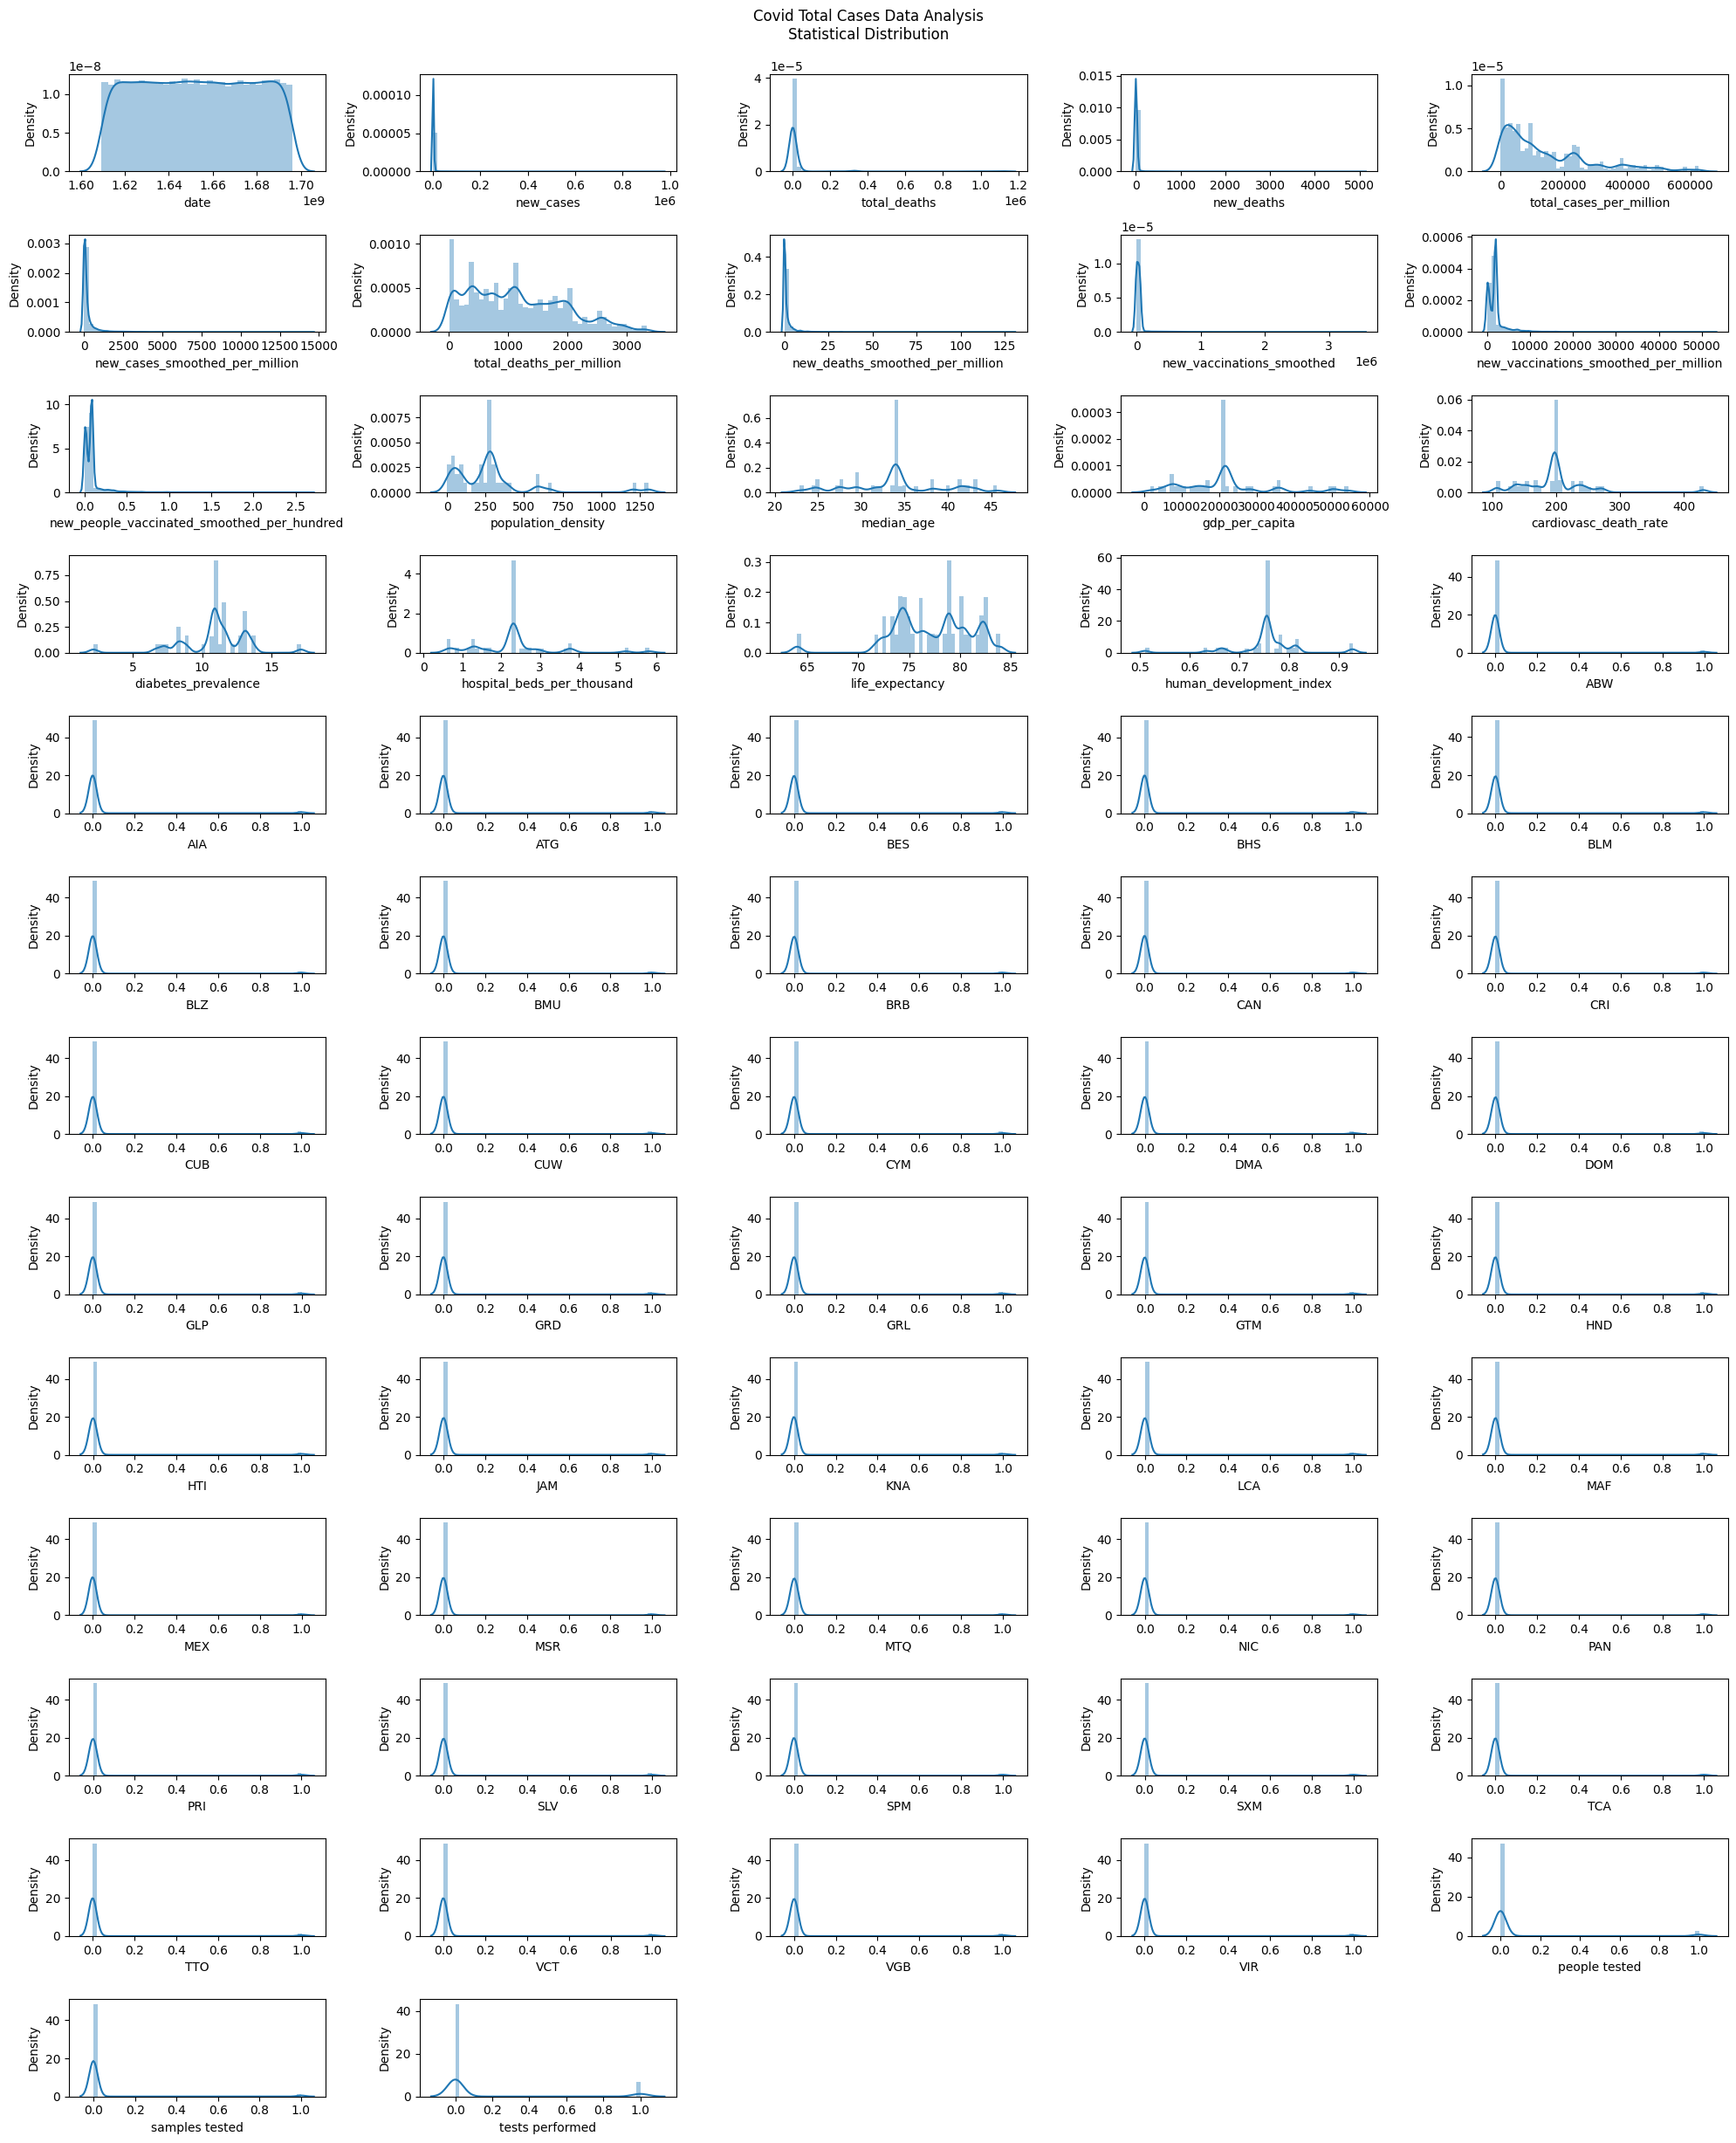

INFO:pycodestyle:13:11: E703 statement ends with a semicolon


In [36]:
fig = plt.figure(figsize=(20, 25))
j = 0
for i in df_training_corr_p_value.columns:
    plt.subplot(13, 5, j+1)
    j += 1
    sns.distplot(df_training_corr_p_value[i])
    # plt.legend(loc='best',fontsize=10)
fig.suptitle('Covid Total Cases Data Analysis\n' +
             'Statistical Distribution')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show();

### Low Variance Filter

Another way of measuring how much information a data column has is to measure its variance. In the limit case where the column cells assume a constant value, the variance would be 0 and the column would be of no help in the discrimination of different groups of data.

The Low Variance Filter calculates each column variance and removes those columns with a variance value below a given threshold. Notice that the variance can only be calculated for numerical columns, i.e. this dimensionality reduction method applies only to numerical columns. Note, too, that the variance value depends on the column numerical range. Therefore data column ranges need to be normalized to make variance values independent from the column domain range.

In [37]:
# For now, I will subset the numeric features into another dataframe:
X_train_num = df_corr_p_value.select_dtypes(include="number")
# X_train_num.shape
# X_train_num.info()

Evaluate the effect of different variance thresholds.

>Threshold=0.00, Features=63
>Threshold=0.05, Features=20
>Threshold=0.10, Features=19
>Threshold=0.15, Features=18
>Threshold=0.20, Features=18


>Threshold=0.25, Features=18
>Threshold=0.30, Features=18
>Threshold=0.35, Features=18
>Threshold=0.40, Features=18
>Threshold=0.45, Features=18
>Threshold=0.50, Features=18
>Threshold=0.55, Features=18
>Threshold=0.60, Features=18
>Threshold=0.65, Features=18
>Threshold=0.70, Features=18
>Threshold=0.75, Features=18
>Threshold=0.80, Features=18
>Threshold=0.85, Features=18
>Threshold=0.90, Features=18
>Threshold=0.95, Features=18
>Threshold=1.00, Features=18


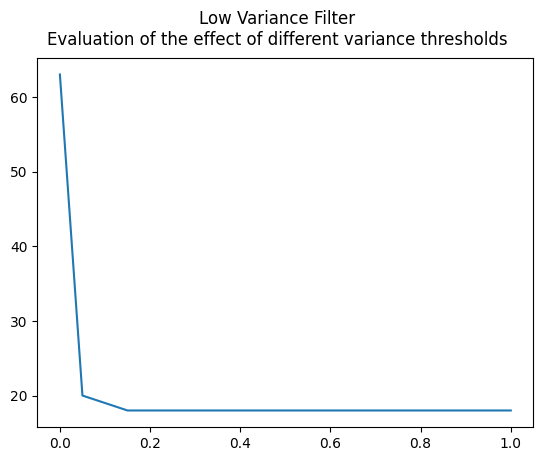

INFO:pycodestyle:25:11: E703 statement ends with a semicolon


In [38]:
thresholds = np.arange(0.0, 1.05, 0.05)

# apply transform with each threshold
results = list()

for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_sel = transform.fit_transform(X_train_num)
    # determine the number of input features
    n_features = X_sel.shape[1]
    print(">Threshold=%.2f, Features=%d" % (t, n_features))
    # store the result
    results.append(n_features)
    # print(X_sel.dtype)

results

# plot the threshold vs the number of selected features
plt.plot(thresholds, results)
plt.suptitle(
    "Low Variance Filter\n" +
    "Evaluation of the effect of different variance thresholds")
plt.show();

The line plot shows the relationship between the threshold and the number of features in the transformed dataset. I can see that with a small threshold of 0.15, 45 features are removed immediately.

First, we fit the estimator to data and call its `get_support()` method. It returns a boolean mask with `True` values for columns which are not dropped.

We can then use this mask to subset our DataFrame like so:

In [39]:
X_train_num_before = X_train_num.copy()

# The default value for the threshold is always 0.
vt = VarianceThreshold()
_ = vt.fit(X_train_num)
mask = vt.get_support()

X_train_num = X_train_num.loc[:, mask]

# Let’s drop features with variances close to 0
vt = VarianceThreshold(threshold=1)
_ = vt.fit(X_train_num)
mask = vt.get_support()

X_train_LowVariance = X_train_num.loc[:, mask]

df_details(
    "After dropping features with variances close to 0",
    {
        'Initial': X_train_num_before,
        'Applying threshold=0': X_train_num,
        'Applying threshold=1': X_train_LowVariance
    })

# X_train_LowVariance.info()

| After dropping features with variances close to 0 | Initial | Applying threshold=0 | Applying threshold=1 |
| :--- | ---: | ---: | ---: |
| Number of observations | 28900 | 28900 | 28900 |
| Number of attributes | 63 | 63 | 18 |
| Size | 1820700 | 1820700 | 520200 |

# Generate Profiling Report
Data profiling is report is available in GitHub: [CIND820_EDA_DataProfiling.html](https://github.com/aamadorc/CIND820/blob/main/CIND820_EDA_DataProfiling.html)/[CIND820_EDA_DataProfiling.ipynb](https://github.com/aamadorc/CIND820/blob/main/CIND820_EDA_DataProfiling.ipynb).

In [40]:
# Generate profiling report
# profile = ProfileReport(
#     data, title="Profiling Report",
#     html={'style':{'fullwith':True}}
# )
# profile

# Modeling

Prepare the Train and Test datasets:

In [41]:
train_dataset = X_train_LowVariance
test_dataset = df_test[X_train_LowVariance.columns]

# train_dataset.columns
# test_dataset.columns

Testing dataset has to be a complete dataset, then any NaN on testing dataset needs to be moved to the training dataset:

In [42]:
train_dataset.shape
test_dataset.shape
# df_details(None, {"Training data set": df_training})

describe_nan(train_dataset)
describe_nan(test_dataset)

# test_dataset.isna().shape
# test_dataset[test_dataset.isnull().any(axis=1)].shape

(28900, 18)

(12387, 18)

,column,nan_count,nan_rate
0,date,0,0.0
1,new_cases,0,0.0
2,total_deaths,0,0.0
3,new_deaths,0,0.0
4,total_cases_per_million,0,0.0
5,new_cases_smoothed_per_million,0,0.0
6,total_deaths_per_million,0,0.0
7,new_deaths_smoothed_per_million,0,0.0
8,new_vaccinations_smoothed,0,0.0
9,new_vaccinations_smoothed_per_million,0,0.0


,column,nan_count,nan_rate
0,date,0,0.000000
1,new_cases,49,0.003956
2,total_deaths,460,0.037136
3,new_deaths,49,0.003956
4,total_cases_per_million,0,0.000000
5,new_cases_smoothed_per_million,49,0.003956
6,total_deaths_per_million,460,0.037136
7,new_deaths_smoothed_per_million,49,0.003956
8,new_vaccinations_smoothed,5064,0.408816
9,new_vaccinations_smoothed_per_million,5064,0.408816


Unfortunately, there are features in the testing dataset with NaN values.

To be able to run the models, I am going to replace NaN values by the mean value of the corresponding column.

In [43]:
for c in test_dataset.columns:
    test_dataset[c] = test_dataset[c].fillna(test_dataset[c].mean())

In [44]:
show_items_in_table(None, train_dataset.columns, 6)


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| `date` | `new_cases` | `total_deaths` | `new_deaths` | `total_cases_per_million` | `new_cases_smoothed_per_million` |
| `total_deaths_per_million` | `new_deaths_smoothed_per_million` | `new_vaccinations_smoothed` | `new_vaccinations_smoothed_per_million` | `population_density` | `median_age` |
| `gdp_per_capita` | `cardiovasc_death_rate` | `diabetes_prevalence` | `hospital_beds_per_thousand` | `life_expectancy` | `total_cases` |


Initiate variables for running models

In [45]:
# Predictive variable
predictor_column = 'total_cases'

X_train = train_dataset.loc[:, train_dataset.columns != predictor_column]
X_test = test_dataset.loc[:, test_dataset.columns != predictor_column]
y_train = train_dataset.loc[:, train_dataset.columns == predictor_column]
y_test = test_dataset.loc[:, test_dataset.columns == predictor_column]

# convert pandas dataframes to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print('Training Features Shape:', X_train.shape)
print('Training Prediction Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Prediction Shape:', y_test.shape)

Training Features Shape: (28900, 17)
Training Prediction Shape: (12387, 17)
Testing Features Shape: (28900, 1)
Testing Prediction Shape: (12387, 1)


In [46]:
model = {}

Models with higher R-squared values are preferred because it means the set of predictor variables in the model is capable of explaining the variation in the response variable well

## Linear Regression
https://www.nickmccullum.com/python-machine-learning/linear-regression-python/

### Create a model

In [47]:
lr = LinearRegression()
model["Linear Regression"] = {"model": lr}

### Train the model

In [48]:
# train this model the training data
exec_time = time.time()

lr.fit(X_train, y_train)

exec_time = time.time() - exec_time

LinearRegression()

### Examine each of the model's coefficients
Linear Regression model has now been trained. We can examine each of the model's coefficients. Large coefficients on a specific variable mean that that variable has a large impact on the value of the variable you're trying to predict. Similarly, small values have small impact.

In [49]:
lr_Coeff = pd.DataFrame(
    lr.coef_,
    columns=train_dataset.
    loc[:, train_dataset.columns != predictor_column].
    columns
)
lr_Coeff = lr_Coeff.transpose()
lr_Coeff.rename(columns={0: 'Coeff'}, inplace=True)
lr_Coeff

,Coeff
date,0.012271
new_cases,14.761466
total_deaths,85.086849
new_deaths,-2325.047296
total_cases_per_million,4.360587
new_cases_smoothed_per_million,-24.709972
total_deaths_per_million,-1204.878232
new_deaths_smoothed_per_million,24674.010368
new_vaccinations_smoothed,-8.907207
new_vaccinations_smoothed_per_million,7.372153


### Making Predictions and testing the model

In [50]:
lr_pred = lr.predict(X_test)

model["Linear Regression"] = {
    "Accuracy": lr.score(X_test, y_test),
    "MAE": metrics.mean_absolute_error(y_test, lr_pred),
    "MSE": metrics.mean_squared_error(y_test, lr_pred),
    "RMSE": np.sqrt(metrics.mean_squared_error(y_test, lr_pred)),
    "Training Time (seconds)": exec_time
}

display(Markdown("> Intercept: %s" % lr.intercept_))

results_to_table("", {
    "Linear Regression": model["Linear Regression"]
})

> Intercept: [-23411752.86373093]

|  | Accuracy | MAE | MSE | RMSE | Training Time (seconds) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Linear Regression | 0.9422784404304934 | 1407548.42856267 | 8746630701897.816 | 2957470.3213891797 | 0.0220034122467041 |


## Random Forest
> https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [51]:
def random_forest(n_estimators, X_train, y_train, X_test, y_test):
    """
    Creates a RandomForestRegressor, fits it with my input and
    calculates all the related metrics. This is used with different
    n_estimators values to determine the optimal tree size for the
    data.

    This is in a function as I'm invoking it through the multiprocess
    module to make use of multiple cpu cores.
    """
    from sklearn.ensemble import RandomForestRegressor
    import numpy as np
    from sklearn import metrics
    import time

    stime = time.time()

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=42
        )

    # Train the model on training data
    rf.fit(X_train, y_train)

    # Use the forest's predict method on the test data
    rf_pred = rf.predict(X_test)

    # Verify/Test
    rf_accuracy = rf.score(X_test, y_test)

    # MAE
    rf_mae = metrics.mean_absolute_error(y_test, rf_pred)

    # MSE
    rf_mse = metrics.mean_squared_error(y_test, rf_pred)

    # RMSE
    rf_rmse = np.sqrt(metrics.mean_squared_error(y_test, rf_pred))

    return rf, rf_accuracy, rf_mae, rf_mse, rf_rmse, time.time() - stime, rf_pred

INFO:pycodestyle:41:80: E501 line too long (81 > 79 characters)


### Making Predictions and testing the model

In [52]:
estimator_sizes = [i for _ in [
    [1],
    range(5, 26, 1),
    range(30, 71, 5),
    range(75, 86, 1),
    range(90, 200, 5),
    ] for i in _]

if __name__ == '__main__':
    def init_worker():
        # signal.signal(signal.SIGINT, signal.SIG_IGN)
        pass

    # Create a process pool with the number of CPUs available
    pool = mp.Pool(mp.cpu_count(), init_worker)
    results = pool.starmap(
        random_forest,
        [
            (x, X_train, y_train, X_test, y_test)
            for x in estimator_sizes
        ]
    )

accuracy = [t[1] for t in results]
mae = [t[2] for t in results]
mse = [t[3] for t in results]
rmse = [t[4] for t in results]
exec_time = [t[5] for t in results]
# pred = [t[6] for t in results]

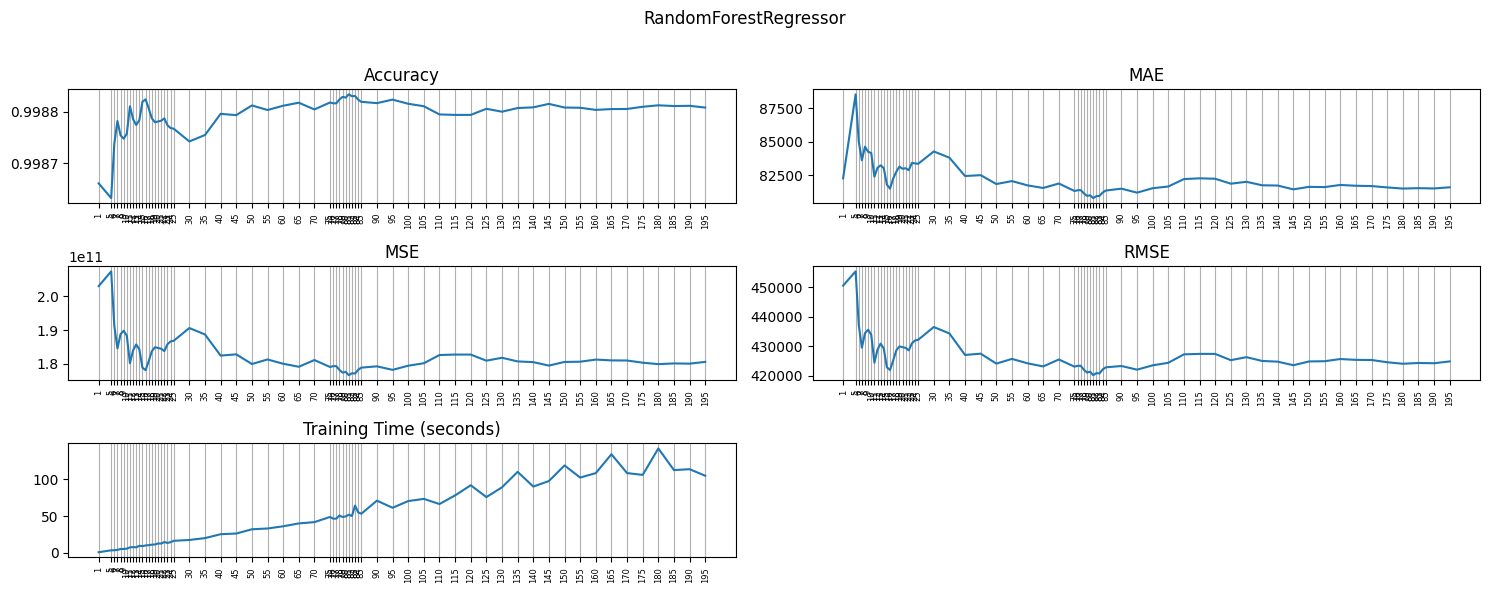

| Comparison | Accuracy | MAE | MSE | RMSE | Training Time (seconds) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| RandomForestRegressor(n_estimators=1) | 0.9986601702214833 | 82270.22927262452 | 203026327831.2694 | 450584.4291930974 | 0.8929872512817383 |
| RandomForestRegressor(n_estimators=5) | 0.9986313866144769 | 88533.43192056188 | 207387949080.44373 | 455398.67048603 | 3.483959913253784 |
| RandomForestRegressor(n_estimators=6) | 0.9987379315412097 | 85011.87629504049 | 191243043533.13882 | 437313.4385462432 | 3.579542636871338 |
| RandomForestRegressor(n_estimators=7) | 0.9987823063897096 | 83617.06081260307 | 184518859100.5793 | 429556.58428265224 | 4.048955678939819 |
| RandomForestRegressor(n_estimators=8) | 0.998754256421324 | 84629.94237910713 | 188769311037.38892 | 434475.90386279067 | 5.266948938369751 |
| RandomForestRegressor(n_estimators=9) | 0.9987476262560707 | 84249.02990590493 | 189773989486.75705 | 435630.565372492 | 5.32451605796814 |
| RandomForestRegressor(n_estimators=10) | 0.9987574212878082 | 84154.71599257286 | 188289734280.2123 | 433923.6502890944 | 5.71493673324585 |
| RandomForestRegressor(n_estimators=11) | 0.9988111135408477 | 82395.21937221574 | 180153670175.35413 | 424445.132114098 | 7.479920148849487 |
| RandomForestRegressor(n_estimators=12) | 0.9987860638012926 | 83055.96855574392 | 183949493134.76224 | 428893.33538161 | 7.8914947509765625 |
| RandomForestRegressor(n_estimators=13) | 0.998774493625886 | 83237.86503219878 | 185702738407.29324 | 430932.40584492276 | 7.559918165206909 |
| RandomForestRegressor(n_estimators=14) | 0.9987837802561463 | 83033.57517674059 | 184295522005.6969 | 429296.5432025943 | 9.623895406723022 |
| RandomForestRegressor(n_estimators=15) | 0.9988199345564605 | 81801.66557412341 | 178817009029.05594 | 422867.60224573355 | 9.181899785995483 |
| RandomForestRegressor(n_estimators=16) | 0.998824654492339 | 81499.33344938242 | 178101790376.36057 | 422021.0781185705 | 10.084472894668579 |
| RandomForestRegressor(n_estimators=17) | 0.9988071184151399 | 82246.56339900939 | 180759057303.40192 | 425157.68522208545 | 10.504885911941528 |
| RandomForestRegressor(n_estimators=18) | 0.9987876275789557 | 82753.91316164796 | 183712531662.82303 | 428616.9988029208 | 11.160880088806152 |
| RandomForestRegressor(n_estimators=19) | 0.998779921988766 | 83145.27940157976 | 184880170795.09818 | 429976.9421667843 | 11.43387484550476 |
| RandomForestRegressor(n_estimators=20) | 0.9987813174995488 | 82986.26834180998 | 184668707044.82983 | 429730.9705441648 | 12.799856901168823 |
| RandomForestRegressor(n_estimators=21) | 0.9987828048443164 | 83021.44202255052 | 184443327559.15558 | 429468.65724887955 | 12.69985818862915 |
| RandomForestRegressor(n_estimators=22) | 0.9987874471275875 | 82879.81166839135 | 183739875717.4307 | 428648.8956213823 | 14.773845911026001 |
| RandomForestRegressor(n_estimators=23) | 0.9987740021751844 | 83415.01436990393 | 185777208636.9158 | 431018.80311294517 | 13.545848846435547 |
| RandomForestRegressor(n_estimators=24) | 0.9987685010917448 | 83385.52937555504 | 186610795699.79443 | 431984.7169747958 | 14.558843612670898 |
| RandomForestRegressor(n_estimators=25) | 0.9987671777461766 | 83351.87904093001 | 186811324151.58948 | 432216.7559819835 | 16.44382071495056 |
| RandomForestRegressor(n_estimators=30) | 0.9987423054773966 | 84273.98493043784 | 190580254709.9377 | 436554.98474984535 | 17.571810245513916 |
| RandomForestRegressor(n_estimators=35) | 0.9987548487854693 | 83808.7984822798 | 188679549248.93 | 434372.59265396796 | 20.109785318374634 |
| RandomForestRegressor(n_estimators=40) | 0.9987962731814054 | 82441.1833232421 | 182402451124.6886 | 427085.9996823691 | 25.42972159385681 |
| RandomForestRegressor(n_estimators=45) | 0.9987937894131337 | 82505.50820483839 | 182778820092.95108 | 427526.39695456356 | 26.36671495437622 |
| RandomForestRegressor(n_estimators=50) | 0.9988127371702421 | 81844.36719786873 | 179907639284.7195 | 424155.2065986218 | 32.13865280151367 |
| RandomForestRegressor(n_estimators=55) | 0.9988037855886993 | 82064.21889517605 | 181264085273.6556 | 425751.201141765 | 33.232645988464355 |
| RandomForestRegressor(n_estimators=60) | 0.9988121707804315 | 81743.00311886116 | 179993465145.0096 | 424256.36724156496 | 36.223610162734985 |
| RandomForestRegressor(n_estimators=65) | 0.9988180850355254 | 81551.4621979619 | 179097269588.8007 | 423198.8534823797 | 40.115570068359375 |
| RandomForestRegressor(n_estimators=70) | 0.9988049026026444 | 81884.3170558996 | 181094822548.60403 | 425552.37344961904 | 41.900545597076416 |
| RandomForestRegressor(n_estimators=75) | 0.9988185463339694 | 81325.35768251662 | 179027368374.02917 | 423116.25869733386 | 48.92947030067444 |
| RandomForestRegressor(n_estimators=76) | 0.9988168812661616 | 81380.78447056125 | 179279678486.8634 | 423414.3106779262 | 46.56150245666504 |
| RandomForestRegressor(n_estimators=77) | 0.9988169035469272 | 81391.59413041951 | 179276302250.49323 | 423410.32374104107 | 46.672489404678345 |
| RandomForestRegressor(n_estimators=78) | 0.9988242978925018 | 81150.85959328742 | 178155826461.11118 | 422085.0938627319 | 50.91144895553589 |
| RandomForestRegressor(n_estimators=79) | 0.9988295123784766 | 80962.03258520315 | 177365667923.08737 | 421148.0356395924 | 48.87847375869751 |
| RandomForestRegressor(n_estimators=80) | 0.9988281354485199 | 81004.05895898928 | 177574316094.12863 | 421395.6764065439 | 49.65746068954468 |
| RandomForestRegressor(n_estimators=81) | 0.998834514580627 | 80797.44987427081 | 176607677057.41666 | 420247.1618671763 | 52.03343963623047 |
| RandomForestRegressor(n_estimators=82) | 0.9988307409458331 | 80940.96626183628 | 177179501349.62244 | 420926.95488602587 | 50.27045464515686 |
| RandomForestRegressor(n_estimators=83) | 0.998831297857623 | 80956.42509976939 | 177095111707.41144 | 420826.7003261692 | 64.42130446434021 |
| RandomForestRegressor(n_estimators=84) | 0.9988240208862749 | 81209.26644773514 | 178197801611.94598 | 422134.8144988115 | 55.20939922332764 |
| RandomForestRegressor(n_estimators=85) | 0.9988197927555991 | 81359.03999259185 | 178838496316.94797 | 422893.00812019577 | 53.33643102645874 |
| RandomForestRegressor(n_estimators=90) | 0.9988172699312318 | 81499.48456715373 | 179220783511.3894 | 423344.75727400876 | 71.18022847175598 |
| RandomForestRegressor(n_estimators=95) | 0.9988241669787062 | 81202.36896321696 | 178175664016.30707 | 422108.5926823891 | 61.443334102630615 |
| RandomForestRegressor(n_estimators=100) | 0.9988160304392695 | 81532.13136837007 | 179408605506.0231 | 423566.5302004198 | 70.59323191642761 |
| RandomForestRegressor(n_estimators=105) | 0.9988111991808335 | 81660.51091889731 | 180140693025.4936 | 424429.84464513516 | 73.57820200920105 |
| RandomForestRegressor(n_estimators=110) | 0.9987951170988314 | 82212.84323887948 | 182577633975.09204 | 427291.04129982885 | 66.54828476905823 |
| RandomForestRegressor(n_estimators=115) | 0.9987942083528611 | 82271.4651019126 | 182715337555.23032 | 427452.14650909207 | 78.32515406608582 |
| RandomForestRegressor(n_estimators=120) | 0.9987942498865728 | 82239.17462662469 | 182709043892.3335 | 427444.7846123912 | 92.156005859375 |
| RandomForestRegressor(n_estimators=125) | 0.9988061890366128 | 81870.09755711634 | 180899887364.4623 | 425323.2739510763 | 76.03417825698853 |
| RandomForestRegressor(n_estimators=130) | 0.9988004757087775 | 82011.18269028944 | 181765636125.013 | 426339.8129720153 | 89.35403490066528 |
| RandomForestRegressor(n_estimators=135) | 0.9988076606129543 | 81751.64833980666 | 180676897290.98596 | 425061.0512514478 | 110.41380882263184 |
| RandomForestRegressor(n_estimators=140) | 0.9988090330841201 | 81731.88605450414 | 180468924766.9468 | 424816.34239627223 | 90.3770182132721 |
| RandomForestRegressor(n_estimators=145) | 0.9988158065988454 | 81448.08690200796 | 179442524366.50937 | 423606.5678982201 | 97.86094427108765 |
| RandomForestRegressor(n_estimators=150) | 0.99880864159277 | 81634.36264309355 | 180528248012.6586 | 424886.1588857168 | 119.17171311378479 |
| RandomForestRegressor(n_estimators=155) | 0.9988081890443534 | 81615.82210694355 | 180596823323.2549 | 424966.8496756599 | 102.61188960075378 |
| RandomForestRegressor(n_estimators=160) | 0.9988040347736479 | 81776.13230352386 | 181226325921.03717 | 425706.85444450757 | 108.69582533836365 |
| RandomForestRegressor(n_estimators=165) | 0.9988056243588128 | 81716.51331430068 | 180985453801.32126 | 425423.85194217926 | 134.41155004501343 |
| RandomForestRegressor(n_estimators=170) | 0.9988058618493673 | 81693.57210073179 | 180949466516.9991 | 425381.55403942836 | 108.73582243919373 |
| RandomForestRegressor(n_estimators=175) | 0.9988101197478612 | 81592.81173718991 | 180304261051.83047 | 424622.4923998144 | 106.28985452651978 |
| RandomForestRegressor(n_estimators=180) | 0.9988129997401566 | 81506.8016316389 | 179867851689.02185 | 424108.3018393083 | 142.30246543884277 |
| RandomForestRegressor(n_estimators=185) | 0.9988115696300917 | 81537.38752964638 | 180084558318.13327 | 424363.7099448223 | 112.79077553749084 |
| RandomForestRegressor(n_estimators=190) | 0.9988120278727799 | 81514.88231932459 | 180015120146.39786 | 424281.8876011535 | 114.04177045822144 |
| RandomForestRegressor(n_estimators=195) | 0.9988085740942615 | 81601.85500431593 | 180538476158.46445 | 424898.19505202 | 105.09187006950378 |


INFO:pycodestyle:33:3: E703 statement ends with a semicolon


In [59]:
fig = plt.figure(figsize=(15, 6))
j = 0
for k, v in {
        'Accuracy': accuracy,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Training Time (seconds)': exec_time
        }.items():
    ax = plt.subplot(3, 2, j+1)
    j += 1
    ax.plot(estimator_sizes, v)
    # ax.legend(k, loc='best', fontsize=10)
    ax.set_title(k)
    ax.set_xticks(estimator_sizes, )
    ax.xaxis.grid(True)
    ax.tick_params(axis='x', labelsize=6, rotation=90)
fig.suptitle('RandomForestRegressor\n')
fig.tight_layout()
# fig.subplots_adjust(top=0.95)

plt.show()


results_to_table("Comparison", {
    "RandomForestRegressor(n_estimators=%d)" % r[0].n_estimators: {
        'Accuracy': r[1],
        'MAE': r[2],
        'MSE': r[3],
        'RMSE': r[4],
        'Training Time (seconds)': r[5],
    } for r in results
});

From the results above, the optimal estimators are found with `n_estimators=16` and `n_estimators=81`. The latter shows smaller `MAE`, `MSE` and `RMSE`. I will proceed then with `n_estimators=81`.

In [61]:
best_rf = [s for s in results if s[1] == max([r[1] for r in results])][0]
model["Random Forest"] = {
    "Accuracy": best_rf[1],
    "MAE": best_rf[2],
    "MSE": best_rf[3],
    "RMSE": best_rf[4],
    "Training Time (seconds)": best_rf[5]
}

results_to_table("", {
    "Random Forest": model["Random Forest"]
})

|  | Accuracy | MAE | MSE | RMSE | Training Time (seconds) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Random Forest | 0.998834514580627 | 80797.44987427081 | 176607677057.41666 | 420247.1618671763 | 52.03343963623047 |


## Logistic Regression

In [62]:
exec_time = time.time()

logreg = LogisticRegression(n_jobs=-1)

model["Logistic Regression"] = {"model": logreg}

logreg.fit(X_train, y_train)

exec_time = time.time() - exec_time

LogisticRegression(n_jobs=-1)

### Making Predictions and testing the model

In [63]:
logreg_pred = logreg.predict(X_test)

model["Logistic Regression"] = {
    "Accuracy": logreg.score(X_test, y_test),
    "MAE": metrics.mean_absolute_error(y_test, logreg_pred),
    "MSE": metrics.mean_squared_error(y_test, logreg_pred),
    "RMSE": np.sqrt(metrics.mean_squared_error(y_test, logreg_pred)),
    "Training Time (seconds)": exec_time
}

display(Markdown("> Intercept: %s" % logreg.intercept_))

results_to_table("", {
    "Logistic Regression": model["Logistic Regression"]
})

> Intercept: [ 1.73814779e-18 -1.24853695e-19  1.15253590e-18 ...  3.71401863e-19
  3.69880204e-19 -3.92605189e-19]

|  | Accuracy | MAE | MSE | RMSE | Training Time (seconds) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Logistic Regression | 0.012997497376281586 | 2175357.539032857 | 129518516.83426173 | 11380.620230649194 | 930.3401651382446 |


## Modeling Results and Comparison

In [64]:

results_to_table("Model", model)

| Model | Accuracy | MAE | MSE | RMSE | Training Time (seconds) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Linear Regression | 0.9422784404304934 | 1407548.42856267 | 8746630701897.816 | 2957470.3213891797 | 0.0220034122467041 |
| Random Forest | 0.998834514580627 | 80797.44987427081 | 176607677057.41666 | 420247.1618671763 | 52.03343963623047 |
| Logistic Regression | 0.012997497376281586 | 2175357.539032857 | 129518516.83426173 | 11380.620230649194 | 930.3401651382446 |



### Scatter plot of predicted values vs read values

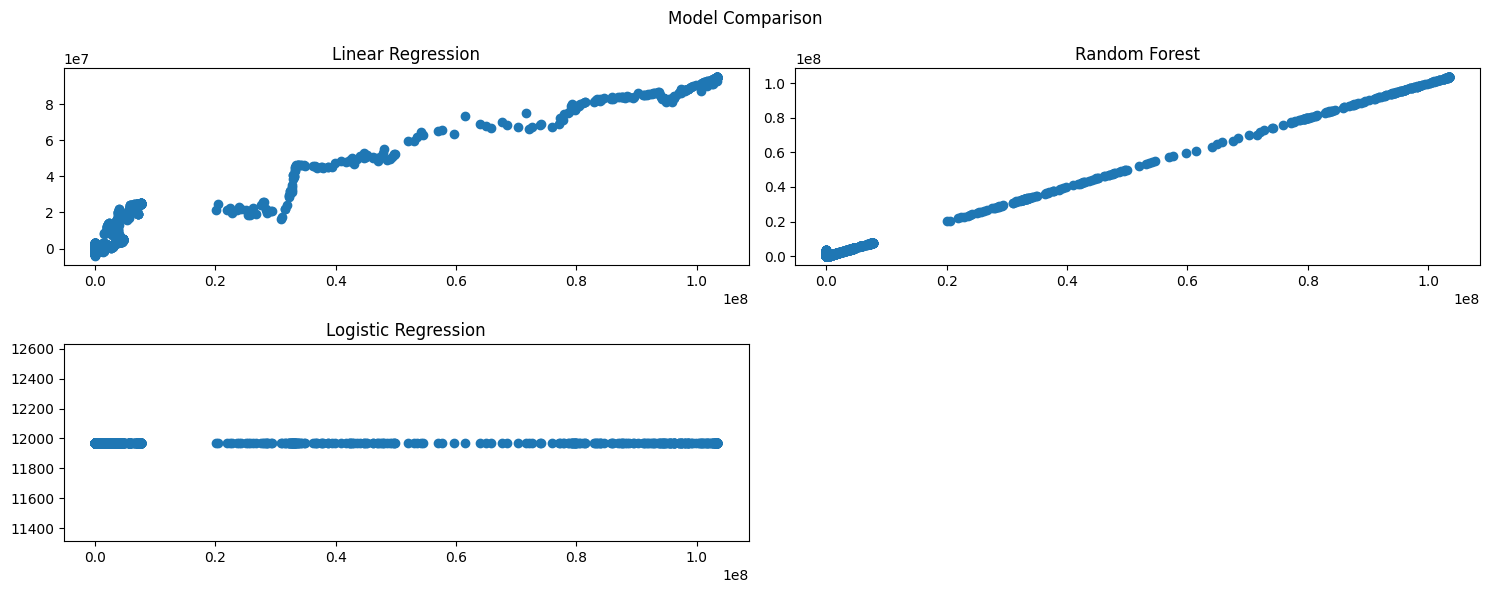

INFO:pycodestyle:18:11: E703 statement ends with a semicolon


In [65]:

fig = plt.figure(figsize=(15, 6))

ax = plt.subplot(2, 2, 1)
ax.scatter(y_test, lr_pred)
ax.set_title("Linear Regression")

ax = plt.subplot(2, 2, 2)
ax.scatter(y_test, best_rf[6])
ax.set_title("Random Forest")

ax = plt.subplot(2, 2, 3)
ax.scatter(y_test, logreg_pred)
ax.set_title("Logistic Regression")

fig.suptitle('Model Comparison')
fig.tight_layout()
fig.show();

### Histogram of the residuals from the machine learning model

Another way to visually assess the performance of the model is to plot its residuals, which are the difference between the actual y-array values and the predicted y-array values.

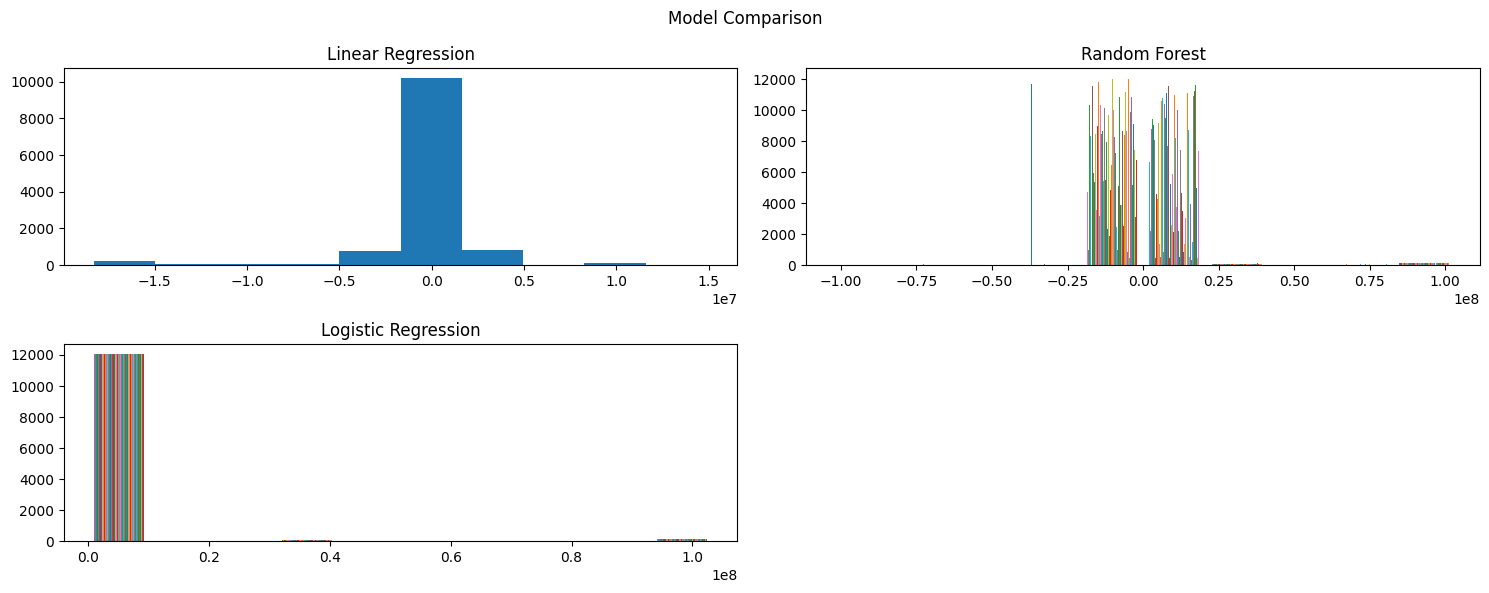

INFO:pycodestyle:22:80: E501 line too long (81 > 79 characters)
INFO:pycodestyle:42:11: E703 statement ends with a semicolon
INFO:pycodestyle:43:1: W391 blank line at end of file


In [69]:
# Use the multiprocess package to generate these plots as they
# take a long time to complete
# def plot_residuals_hist(ax, label, y_test, pred):
#     ax.hist(y_test - pred)
#     ax.set_title(label)
#     return ax


# if __name__ == '__main__':
#     def init_worker():
#         # signal.signal(signal.SIGINT, signal.SIG_IGN)
#         pass

#     fig = plt.figure(figsize=(15, 6))

#     pool = mp.Pool(mp.cpu_count(), init_worker)
#     results = pool.starmap(
#         plot_residuals_hist,
#         [
#             (plt.subplot(2, 2, 1), "Linear Regression", y_test, lr_pred),
#             (plt.subplot(2, 2, 2), "Random Forest", y_test, best_rf[6]),
#             (plt.subplot(2, 2, 3), "Logistic Regression", y_test, logreg_pred),
#         ]
#     )

#     fig.suptitle('Model Comparison')
#     fig.tight_layout()
#     fig.show();

fig = plt.figure(figsize=(15, 6))
ax = plt.subplot(2, 2, 1)
ax.hist(y_test - lr_pred)
ax.set_title("Linear Regression")
ax = plt.subplot(2, 2, 2)
ax.hist(y_test - best_rf[6])
ax.set_title("Random Forest")
ax = plt.subplot(2, 2, 3)
ax.hist(y_test - logreg_pred)
ax.set_title("Logistic Regression")
fig.suptitle('Model Comparison')
fig.tight_layout()
fig.show();
